# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("archive/clean.csv", sep = '\t')

In [3]:
df_tr

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
0,0,1372636858620000589,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0,0,0,1,1,22.0
1,1,1372637303620000596,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0,0,1,0,1,18.0
2,2,1372636951620000320,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0,0,0,1,1,64.0
3,3,1372636854620000520,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1,1,42.0
4,4,1372637091620000337,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1710663,1388660427620000585,NaN,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2895,2014,1,2,11,3,0,0,1,1,193.0
1704755,1710665,1404171463620000698,NaN,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1,1,31.0
1704756,1710666,1404171367620000670,NaN,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,2014,6,30,23,0,0,0,1,1,29.0
1704757,1710668,1404141826620000248,NaN,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,2014,6,30,15,0,0,1,0,1,61.0


In [ ]:
# https://scicomp.stackexchange.com/questions/19586/parallelizing-a-for-loop-in-python
from numba import jit, prange

# https://stackoverflow.com/questions/1926741/how-do-i-parse-a-string-representing-a-nested-list-into-an-actual-list
import ast

@jit #(nopython=True, parallel=True)
def parallel_PolylineType(column="POLYLINE", Partition = 81179,WorkingSet = 21):
    for i in range(Partition): #df.shape[0] mod 21 == 0
            for j in range(81179): #df.shape[0]/21
                (df_tr[column][i*WorkingSet:(i+1)*WorkingSet]).apply(ast.literal_eval)

parallel_PolylineType(column="POLYLINE")

/tmp/ipykernel_1790/766260267.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "parallel_PolylineType" failed type inference due to: Untyped global name 'df_tr': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "../../tmp/ipykernel_1790/766260267.py", line 11:
<source missing, REPL/exec in use?>

  @jit #(nopython=True, parallel=True)
/tmp/ipykernel_1790/766260267.py:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "parallel_PolylineType" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../tmp/ipykernel_1790/766260267.py", line 9:
<source missing, REPL/exec in use?>

  @jit #(nopython=True, parallel=True)
/opt/conda/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "parallel_PolylineType" was compiled in object mode without forceobj=True, but has

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [23]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [24]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
0,0,1372636858620000589,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0,0,0,1,1,22.0
1,1,1372637303620000596,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0,0,1,0,1,18.0
2,2,1372636951620000320,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0,0,0,1,1,64.0
3,3,1372636854620000520,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1,1,42.0
4,4,1372637091620000337,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1710663,1388660427620000585,NaN,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2895,2014,1,2,11,3,0,0,1,1,193.0
1704755,1710665,1404171463620000698,NaN,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1,1,31.0
1704756,1710666,1404171367620000670,NaN,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,2014,6,30,23,0,0,0,1,1,29.0
1704757,1710668,1404141826620000248,NaN,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,2014,6,30,15,0,0,1,0,1,61.0


In [25]:
df_tr.describe()

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
count,1.704759e+06,1.704759e+06,364344.000000,804773.000000,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1704759.0,1.704759e+06
mean,8.552689e+05,1.388621e+18,24491.948754,30.258887,2.000035e+07,1.388621e+09,7.189021e+02,2.013498e+03,6.587473e+00,1.559422e+01,1.192176e+01,3.055335e+00,2.137217e-01,4.786923e-01,3.075860e-01,1.0,4.792681e+01
std,4.937930e+05,9.180305e+15,19624.119876,17.739099,2.112083e+02,9.180305e+06,6.846122e+02,4.999960e-01,3.412563e+00,8.843019e+00,6.234368e+00,1.967603e+00,4.099327e-01,4.995459e-01,4.614943e-01,0.0,4.564081e+01
min,0.000000e+00,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,4.276875e+05,1.380731e+18,6596.000000,15.000000,2.000017e+07,1.380731e+09,4.050000e+02,2.013000e+03,4.000000e+00,8.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,2.700000e+01
50%,8.551960e+05,1.388490e+18,18759.000000,27.000000,2.000034e+07,1.388490e+09,6.000000e+02,2.013000e+03,7.000000e+00,1.500000e+01,1.200000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,4.000000e+01
75%,1.282842e+06,1.396749e+18,40808.000000,49.000000,2.000052e+07,1.396749e+09,8.700000e+02,2.014000e+03,1.000000e+01,2.300000e+01,1.700000e+01,5.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.0,5.800000e+01
max,1.710669e+06,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09,5.820000e+04,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,3.880000e+03


### Create a Prediction File

In [26]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=718.902126341612 median=600.0 std=684.6122055651741


In [27]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("archive/sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

In [28]:
df_tr.columns

Index(['Unnamed: 0', 'TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', 'YR', 'MON', 'DAY',
       'HR', 'WK', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'DAY_TYPE_A',
       'POLYLINE_SEGMENTS'],
      dtype='object')

Using: 1646739/1704759


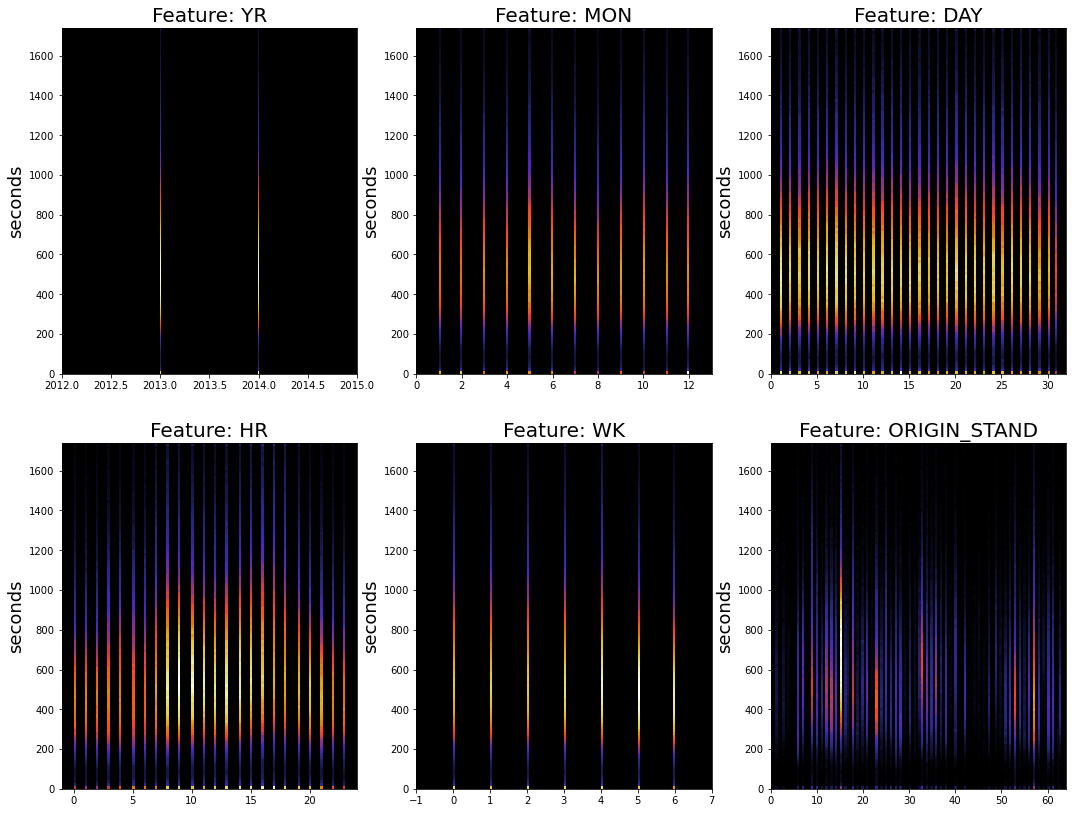

In [29]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3/2 #factor of sigma(std dev)

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


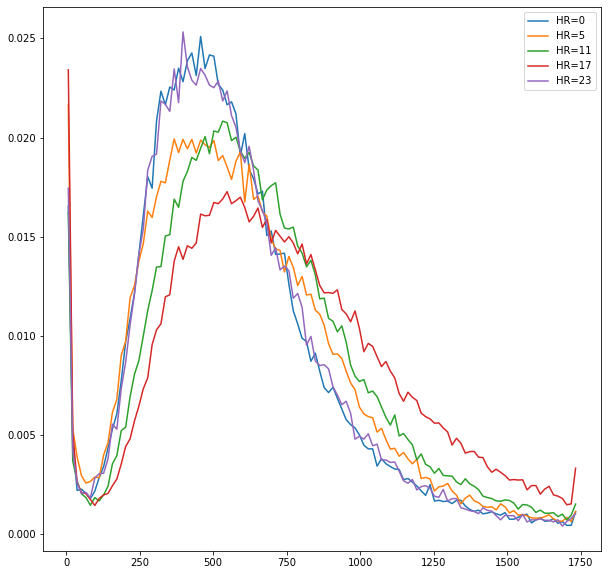

In [30]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [31]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.pairplot(df_tr)
# plt.show()

In [32]:
df_tr

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
0,0,1372636858620000589,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0,0,0,1,1,22.0
1,1,1372637303620000596,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0,0,1,0,1,18.0
2,2,1372636951620000320,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0,0,0,1,1,64.0
3,3,1372636854620000520,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1,1,42.0
4,4,1372637091620000337,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1710663,1388660427620000585,NaN,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2895,2014,1,2,11,3,0,0,1,1,193.0
1704755,1710665,1404171463620000698,NaN,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1,1,31.0
1704756,1710666,1404171367620000670,NaN,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,2014,6,30,23,0,0,0,1,1,29.0
1704757,1710668,1404141826620000248,NaN,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,2014,6,30,15,0,0,1,0,1,61.0


In [33]:
df_tr.describe()

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
count,1.704759e+06,1.704759e+06,364344.000000,804773.000000,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1.704759e+06,1704759.0,1.704759e+06
mean,8.552689e+05,1.388621e+18,24491.948754,30.258887,2.000035e+07,1.388621e+09,7.189021e+02,2.013498e+03,6.587473e+00,1.559422e+01,1.192176e+01,3.055335e+00,2.137217e-01,4.786923e-01,3.075860e-01,1.0,4.792681e+01
std,4.937930e+05,9.180305e+15,19624.119876,17.739099,2.112083e+02,9.180305e+06,6.846122e+02,4.999960e-01,3.412563e+00,8.843019e+00,6.234368e+00,1.967603e+00,4.099327e-01,4.995459e-01,4.614943e-01,0.0,4.564081e+01
min,0.000000e+00,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,4.276875e+05,1.380731e+18,6596.000000,15.000000,2.000017e+07,1.380731e+09,4.050000e+02,2.013000e+03,4.000000e+00,8.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,2.700000e+01
50%,8.551960e+05,1.388490e+18,18759.000000,27.000000,2.000034e+07,1.388490e+09,6.000000e+02,2.013000e+03,7.000000e+00,1.500000e+01,1.200000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,4.000000e+01
75%,1.282842e+06,1.396749e+18,40808.000000,49.000000,2.000052e+07,1.396749e+09,8.700000e+02,2.014000e+03,1.000000e+01,2.300000e+01,1.700000e+01,5.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.0,5.800000e+01
max,1.710669e+06,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09,5.820000e+04,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,3.880000e+03


In [34]:
df_tr.isnull().sum() #could be B and C type rides, OK to keep

Unnamed: 0                 0
TRIP_ID                    0
ORIGIN_CALL          1340415
ORIGIN_STAND          899986
TAXI_ID                    0
TIMESTAMP                  0
MISSING_DATA               0
POLYLINE                   0
LEN                        0
YR                         0
MON                        0
DAY                        0
HR                         0
WK                         0
CALL_TYPE_A                0
CALL_TYPE_B                0
CALL_TYPE_C                0
DAY_TYPE_A                 0
POLYLINE_SEGMENTS          0
dtype: int64

In [35]:
print(df_tr.shape) #Find duplicates
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
print(any(list(df_tr.duplicated(keep=False)))) #duplicates are True

(1704759, 19)
False


In [36]:
df_tr[df_tr.duplicated()] #How are these duplicates? Not dropping either one

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS


In [37]:
# print(set(list(df_tr["CALL_TYPE"])))
# print(set(list(df_tr["ORIGIN_STAND"])))

In [38]:
df_tr["MISSING_DATA"].value_counts() #points have missings Polyline data

False    1704759
Name: MISSING_DATA, dtype: int64

In [39]:
df_goodPolyline = df_tr.drop(df_tr[df_tr['MISSING_DATA'] == True].index)

In [40]:
df_goodPolyline[df_goodPolyline["POLYLINE"] == "[]"] #check for empty polylines

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS


In [41]:
df_goodPolyline = df_goodPolyline.drop(df_goodPolyline[df_goodPolyline["POLYLINE"] == "[]"]["POLYLINE"].index)
df_goodPolyline

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
0,0,1372636858620000589,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0,0,0,1,1,22.0
1,1,1372637303620000596,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0,0,1,0,1,18.0
2,2,1372636951620000320,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0,0,0,1,1,64.0
3,3,1372636854620000520,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1,1,42.0
4,4,1372637091620000337,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1710663,1388660427620000585,NaN,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2895,2014,1,2,11,3,0,0,1,1,193.0
1704755,1710665,1404171463620000698,NaN,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1,1,31.0
1704756,1710666,1404171367620000670,NaN,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,2014,6,30,23,0,0,0,1,1,29.0
1704757,1710668,1404141826620000248,NaN,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,2014,6,30,15,0,0,1,0,1,61.0


In [42]:
df_cleaned = df_goodPolyline
df_cleaned

,Unnamed: 0,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
0,0,1372636858620000589,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0,0,0,1,1,22.0
1,1,1372637303620000596,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0,0,1,0,1,18.0
2,2,1372636951620000320,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0,0,0,1,1,64.0
3,3,1372636854620000520,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1,1,42.0
4,4,1372637091620000337,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1710663,1388660427620000585,NaN,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2895,2014,1,2,11,3,0,0,1,1,193.0
1704755,1710665,1404171463620000698,NaN,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1,1,31.0
1704756,1710666,1404171367620000670,NaN,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,2014,6,30,23,0,0,0,1,1,29.0
1704757,1710668,1404141826620000248,NaN,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,2014,6,30,15,0,0,1,0,1,61.0


In [43]:
#change represnetation of Call Type and Day Type to one-hot encoding
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [44]:
print(list(set(list(df_cleaned["CALL_TYPE"]))))
print(list(set(list(df_cleaned["DAY_TYPE"])))) # Kaggle only has 1 day type on test data, matches training

KeyError: 'CALL_TYPE'

In [ ]:
df_cleaned = pd.get_dummies(df_cleaned, columns=['CALL_TYPE'])
#creates 3 columns for each CALL_TYPE_X: X in {A, B, C} each either 1 and rest 0
df_tr = df_cleaned
df_tr

In [ ]:
df_tr#["CALL_TYPE"]

In [ ]:
df_tr = pd.get_dummies(df_tr, columns=['DAY_TYPE'])

In [ ]:
df_tr
#created 1 column for single DAY_TYPE_A
#All data from a normal day or weekend; no special/holidays or day before those days

# CSE 151A Methods

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor  #Might be good for categorial rpediction
from sklearn.ensemble import RandomForestRegressor  #Might be good for categorial rpediction
from sklearn.ensemble import AdaBoostRegressor #Might be good for categorial rpediction
from sklearn import svm

#To try:
from sklearn.linear_model import Ridge #L2
from sklearn.linear_model import Lasso #L1
#Maybe Try Kernel Methods as well for higher-dim/polynomial embedding? 

models = []

In [136]:
# # First n samples to analyze. Set to -1 to use all data
# end = -1

# outlier_threshold = 3/2 #factor of sigma(std dev)

# # "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# # This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# # VERRRRRY long taxi trips in the dataset)
# df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# # Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# # such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# # how many 30s trips, etc. )
# buckets = (int(mean + outlier_threshold * std) // 15)

# print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# # Now, we visualize some features that we think might be useful
# for idx, v in enumerate(list(set(df_tr.columns).difference("LEN"))):#["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
#   # idx // 3 = row, idx % 3 = column
#   ax = axs[idx//3, idx%3]
  
#   # Remove any rows with invalid values
#   df_subset = df_trimmed.dropna(subset=v)
  
#   # Create a histogram. Look up the documentation for more details
#   ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
#   # Some stylistic things to make the graphs look nice
#   ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
#   ax.set_facecolor("black")
#   ax.set_ylabel("seconds", fontsize=18)
#   ax.set_title(f"Feature: {v}", fontsize=20)


In [137]:
df_tr["POLYLINE_SEGMENTS"] = [i/15 for i in df_tr["LEN"]]
df_tr

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,POLYLINE_SEGMENTS
0,1372636858620000589,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0,0,0,1,1,22.0
1,1372637303620000596,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0,0,1,0,1,18.0
2,1372636951620000320,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0,0,0,1,1,64.0
3,1372636854620000520,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0,0,0,1,1,42.0
4,1372637091620000337,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0,0,0,1,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710663,1388660427620000585,NaN,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2895,2014,1,2,11,3,0,0,1,1,193.0
1710665,1404171463620000698,NaN,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,2014,6,30,23,0,0,0,1,1,31.0
1710666,1404171367620000670,NaN,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,2014,6,30,23,0,0,0,1,1,29.0
1710668,1404141826620000248,NaN,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,2014,6,30,15,0,0,1,0,1,61.0


In [138]:
#TODO: maek Origin Stand NaN to be -1
features = list(set(df_test.columns).difference({"ORIGIN_STAND","DAY_TYPE", "WK", "ORIGIN_CALL", "TRIP_ID","POLYLINE","LEN",'YR','MON','YR','TAXI_ID','MISSING_DATA'}))
# f1 = list(set(df_tr.columns).difference({"ORIGIN_STAND","WK", "ORIGIN_CALL", "TRIP_ID","POLYLINE","LEN",'YR','MON','YR','TAXI_ID','MISSING_DATA'}))
#origin call and stand might be important, but they are NaN - need to process data again
#need to embed poly line segment count rather than time as an input
features

['CALL_TYPE_C', 'CALL_TYPE_A', 'TIMESTAMP', 'CALL_TYPE_B']

In [139]:
df_tr.columns

Index(['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP',
       'MISSING_DATA', 'POLYLINE', 'LEN', 'YR', 'MON', 'DAY', 'HR', 'WK',
       'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'DAY_TYPE_A',
       'POLYLINE_SEGMENTS'],
      dtype='object')

In [140]:
features
# print(df_tr.columns)
df_tr[features]

,CALL_TYPE_C,CALL_TYPE_A,TIMESTAMP,CALL_TYPE_B
0,1,0,1372636858,0
1,0,0,1372637303,1
2,1,0,1372636951,0
3,1,0,1372636854,0
4,1,0,1372637091,0
...,...,...,...,...
1710663,1,0,1388660427,0
1710665,1,0,1404171463,0
1710666,1,0,1404171367,0
1710668,0,0,1404141826,1


In [141]:
df_tr.to_csv("archive/clean.csv", sep = '\t')

In [142]:
#Define input (relevent features?) and output 
X = df_tr[features]
y = df_tr['LEN']

#Might be good to norm the inputs in some way
# y

In [143]:
test_porition = 0.1 #0.2
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = test_porition) 
# [len(i)for i in [X_train, X_test, y_train, y_test]]

In [144]:
#Number of Cross Fold Validation:
CV = 5

K-Nearest Neighbors

In [145]:
KNeighborsRegressor().get_params().keys() #centroids - choose similarity metric other than L2?

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [146]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neighbor_count = [i for i in range(1,8,2)]
num_neighbors = {"n_neighbors" : neighbor_count}
knn = GridSearchCV(KNeighborsRegressor(), num_neighbors, cv = CV)
knn.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7]})

In [147]:
print(knn.best_estimator_)
models.append(knn)

KNeighborsRegressor(n_neighbors=7)


In [148]:
y_train_pred =knn.predict(X_train) 
y_test_pred =knn.predict(X_test) 
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared error: 626.2348824492049
R-squared: 0.1671607999051291


max R-squared and 0 RMSE sounds like overitting

Decision Tree

In [149]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [150]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
tree_depth = [i for i in range(3,6)]
depth = {"max_depth" : tree_depth}
dtree = GridSearchCV(DecisionTreeRegressor(), depth, cv = CV)
dtree.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5]})

In [151]:
dtree.best_estimator_
models.append(dtree)

In [152]:
y_train_pred =dtree.predict(X_train) 
y_test_pred =dtree.predict(X_test) 
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared error: 683.8077687232895
R-squared: 0.006987513676385282


Looks promising - but not a deep net (uncertianty metric, can always underfit w/params)

AdaBoost

In [153]:
AdaBoostRegressor().get_params().keys()
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
#n_estimators
# exp loss? square loss? default is linear


dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [154]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
estimators = [i for i in range(50,70,5)]
param_search = {"n_estimators" : estimators}
adab = GridSearchCV(AdaBoostRegressor(), param_search, cv = CV, verbose = 4)
adab.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................n_estimators=50;, score=-2.957 total time=  12.7s
[CV 2/5] END ..................n_estimators=50;, score=-0.043 total time=   9.9s
[CV 3/5] END .................n_estimators=50;, score=-84.284 total time=  43.8s
[CV 4/5] END ..................n_estimators=50;, score=-9.887 total time=  17.0s
[CV 5/5] END .................n_estimators=50;, score=-20.954 total time=  25.0s
[CV 1/5] END ..................n_estimators=55;, score=-4.770 total time=  15.6s
[CV 2/5] END ..................n_estimators=55;, score=-0.042 total time=  10.2s
[CV 3/5] END .................n_estimators=55;, score=-82.804 total time=  41.1s
[CV 4/5] END .................n_estimators=55;, score=-95.144 total time=  42.7s
[CV 5/5] END .................n_estimators=55;, score=-20.295 total time=  30.3s
[CV 1/5] END .................n_estimators=60;, score=-17.998 total time=  18.9s
[CV 2/5] END ..................n_estimators=60;, 

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'n_estimators': [50, 55, 60, 65]}, verbose=4)

In [155]:
adab.best_params_
models.append(adab)

In [156]:
y_train_pred =adab.predict(X_train) 
y_test_pred =adab.predict(X_test) 
print(f"Root mean squared error: {sqrt(mse(y_train.values, y_train_pred))}" )
print(f"R-squared: {r2_score(y_train.values, y_train_pred)}")

Root mean squared error: 7032.797815788838
R-squared: -104.03714597246777


# Testing

In [157]:
df_test = pd.read_csv("archive/test_public.csv")
df_test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [158]:
print(list(set(list(df_test["CALL_TYPE"]))))
print(list(set(list(df_test["DAY_TYPE"])))) # Kaggle only has 1 day type on test data, matches training

df_test = pd.get_dummies(df_test, columns=['CALL_TYPE'])
#creates 3 columns for each CALL_TYPE_X: X in {A, B, C} each either 1 and rest 0
df_test

['B', 'C', 'A']
['A']


,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,T1,NaN,15.0,20000542,1408039037,A,False,0,1,0
1,T2,NaN,57.0,20000108,1408038611,A,False,0,1,0
2,T3,NaN,15.0,20000370,1408038568,A,False,0,1,0
3,T4,NaN,53.0,20000492,1408039090,A,False,0,1,0
4,T5,NaN,18.0,20000621,1408039177,A,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...
315,T323,70885.0,NaN,20000430,1419171485,A,False,1,0,0
316,T324,NaN,53.0,20000020,1419170802,A,False,0,1,0
317,T325,NaN,NaN,20000207,1419172121,A,False,0,0,1
318,T326,76232.0,NaN,20000667,1419171980,A,False,1,0,0


In [159]:
#TODO: clean origin stand NaN to be -1
test_features = features#list(set(df_test.columns).difference({"ORIGIN_STAND","DAY_TYPE", "WK", "ORIGIN_CALL", "TRIP_ID","POLYLINE","LEN",'YR','MON','YR','TAXI_ID','MISSING_DATA'}))
test_features

['CALL_TYPE_C', 'CALL_TYPE_A', 'TIMESTAMP', 'CALL_TYPE_B']

In [160]:
testing_X = df_test[test_features]
# testing_y = df_test['LEN']
testing_X

,CALL_TYPE_C,CALL_TYPE_A,TIMESTAMP,CALL_TYPE_B
0,0,0,1408039037,1
1,0,0,1408038611,1
2,0,0,1408038568,1
3,0,0,1408039090,1
4,0,0,1408039177,1
...,...,...,...,...
315,0,1,1419171485,0
316,0,0,1419170802,1
317,1,0,1419172121,0
318,0,1,1419171980,0


In [180]:
model_to_predictions = {}
for m in models:
#     print(m)
    test_y_pred = m.predict(testing_X) 
    model_to_predictions[m] = test_y_pred
model_to_predictions

{GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
              param_grid={'n_neighbors': [1, 3, 5, 7]}): array([113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142857,
        113.57142857, 113.57142857, 113.57142857, 113.57142

In [181]:
# # Sample submission file that is given on kaggle
# df_sample = pd.read_csv("archive/sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)

# predict()

In [182]:
V = "K" #item index = 0 --> key
for i,item in enumerate(model_to_predictions.items()):
    df_sample = pd.read_csv("archive/sampleSubmission.csv")
    df_sample["TRAVEL_TIME"] = item[V == "K"]
    df_sample.to_csv(f"submissions/my_pred{i}.csv", index=None)


In [183]:
for m in models:
    print(m)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7]})
GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5]})
GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'n_estimators': [50, 55, 60, 65]}, verbose=4)


In [185]:
set(f1).difference(set(features))

{'DAY', 'DAY_TYPE_A', 'HR', 'POLYLINE_SEGMENTS'}